# Marekting Uplift Classsification Model
The objective of this machine learning project was to help a CRM company's marketing team identify customers that are likely to upgrade their subscription plan when offered a free trial for a higher subscription plan for a month. To solve the problem, I developed a multiclass classification model that predicts whether a customer converts, doesn't covert, or downgrades one's subscription plan. 

Note: datasets for this project are not publicly available. 

In [1]:
! pip install --upgrade sagemaker
!pip install mlflow

In [2]:
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import boto3

# Set this variable to your MLflow server's DNS name
address = '---'
mlflow_server_test = address.format('zulu', '---')
mlflow_server_live = address.format('alpha', '---')

# Tracking URI
mlflow_tracking_URI = mlflow_server_live
print ("MLflow Tracking URI: %s" % (mlflow_tracking_URI))

# Importing MLflow and setting the Tracking UI
mlflow.set_tracking_uri(mlflow_tracking_URI)
experiment_name = "upliftmodel"
experiment_id = mlflow.set_experiment(experiment_name)

MLflow Tracking URI: http://k8s.alpha.pdw.services:31005


In [3]:
# Importing data from AWS S3
s3 = boto3.resource('s3')
path_to_file = "---"
raw = pd.read_parquet("---")
raw.shape

(439012, 62)

### Target Distribution

In [4]:
raw.groupby(['class_numeric', 'class']).size()

class_numeric  class             
0              sleeping              431973
1              trial_converted         4510
2              trial_nonconverted      2529
dtype: int64

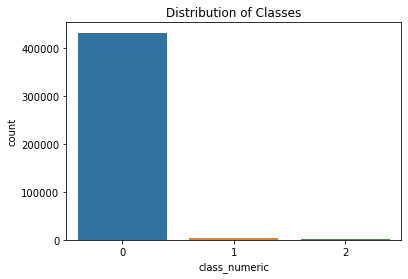

In [5]:
# Plotting target distribution
sns.countplot(x="class_numeric", data=raw).set_title('Distribution of Classes')
plt.savefig('distribution.png')
plt.show()


In [6]:
# Sleeping companies remain idle for longer periods, hence can appear in the data more than once.
raw.groupby('class').key_company.nunique()

class
sleeping              132477
trial_converted         4423
trial_nonconverted      2412
Name: key_company, dtype: int64

### Data Cleaning

In [7]:
# Checking for all columns
print(raw.columns.values.tolist())

In [8]:
# Checkimg for null values
nulls = raw.isnull().sum().to_frame('null_value_count')
nulls.loc[nulls['null_value_count'] > 0]

In [9]:
# Select, reorder and re-format relevant data
raw = raw[(raw['billing_plan_tier'] != 'Enterprise')]

df = raw[['key_company', 'class_numeric', 'subregion', 'key_companyindustry', 'key_companyenrichedindustrygroup',\
          'key_companyenrichedsize', 'month', 'paying_first_diff', 'total_seat_count_1m_before',\
          'total_seat_count_2q_before', 'total_seat_count_less1m_less2q_growth', 'company_mrr_fx_usd_1m_before',\
          'company_mrr_fx_usd_2q_before', 'deal_revenue_2m_before', 'deal_revenue_less1m_less2q_growth',\
          'revenueperseat_less1m_less2q_growth', 'TwoFA_All_Essential', 'Academy_All_Essential',\
          'Activities_All_Essential', 'Billing_All_Essential', 'Calendar_All_Essential', 'CalendarSync_All_Essential',\
          'Chatbot_All_Essential', 'ContactSync_All_Essential', 'Contacts_All_Essential', 'CustomFields_All_Essential',\
          'Deals_All_Essential', 'Email_All_Essential', 'Export_All_Essential', 'Filters_All_Essential',\
          'GmailAddOn_All_Essential', 'Goals_All_Essential', 'Import_All_Essential', 'Insights_All_Essential',\
          'Invoicing_All_Essential', 'LeadsInbox_All_Essential', 'LiveChat_All_Essential', 'Marketplace_All_Essential',\
          'Mergeduplicates_All_Essential', 'Mobile_All_Essential', 'Pipeline_All_Essential',\
          'Pipelinecustomization_All_Essential', 'Products_All_Essential', 'SalesAssistant_All_Essential',\
          'Scheduler_All_Essential', 'Search_All_Essential', 'SecurityDashboard_All_Essential', 'Settings_All_Essential',\
          'Statistics_All_Essential', 'WebForms_All_Essential', 'ZoomIntegration_All_Essential']].copy()

df.reset_index(inplace=True)

df['class_numeric'] = pd.to_numeric(df['class_numeric'])

df.drop_duplicates(subset=None, keep='first', inplace=True)

df.shape

Text(0.5, 1.0, 'Correlation Heatmap')

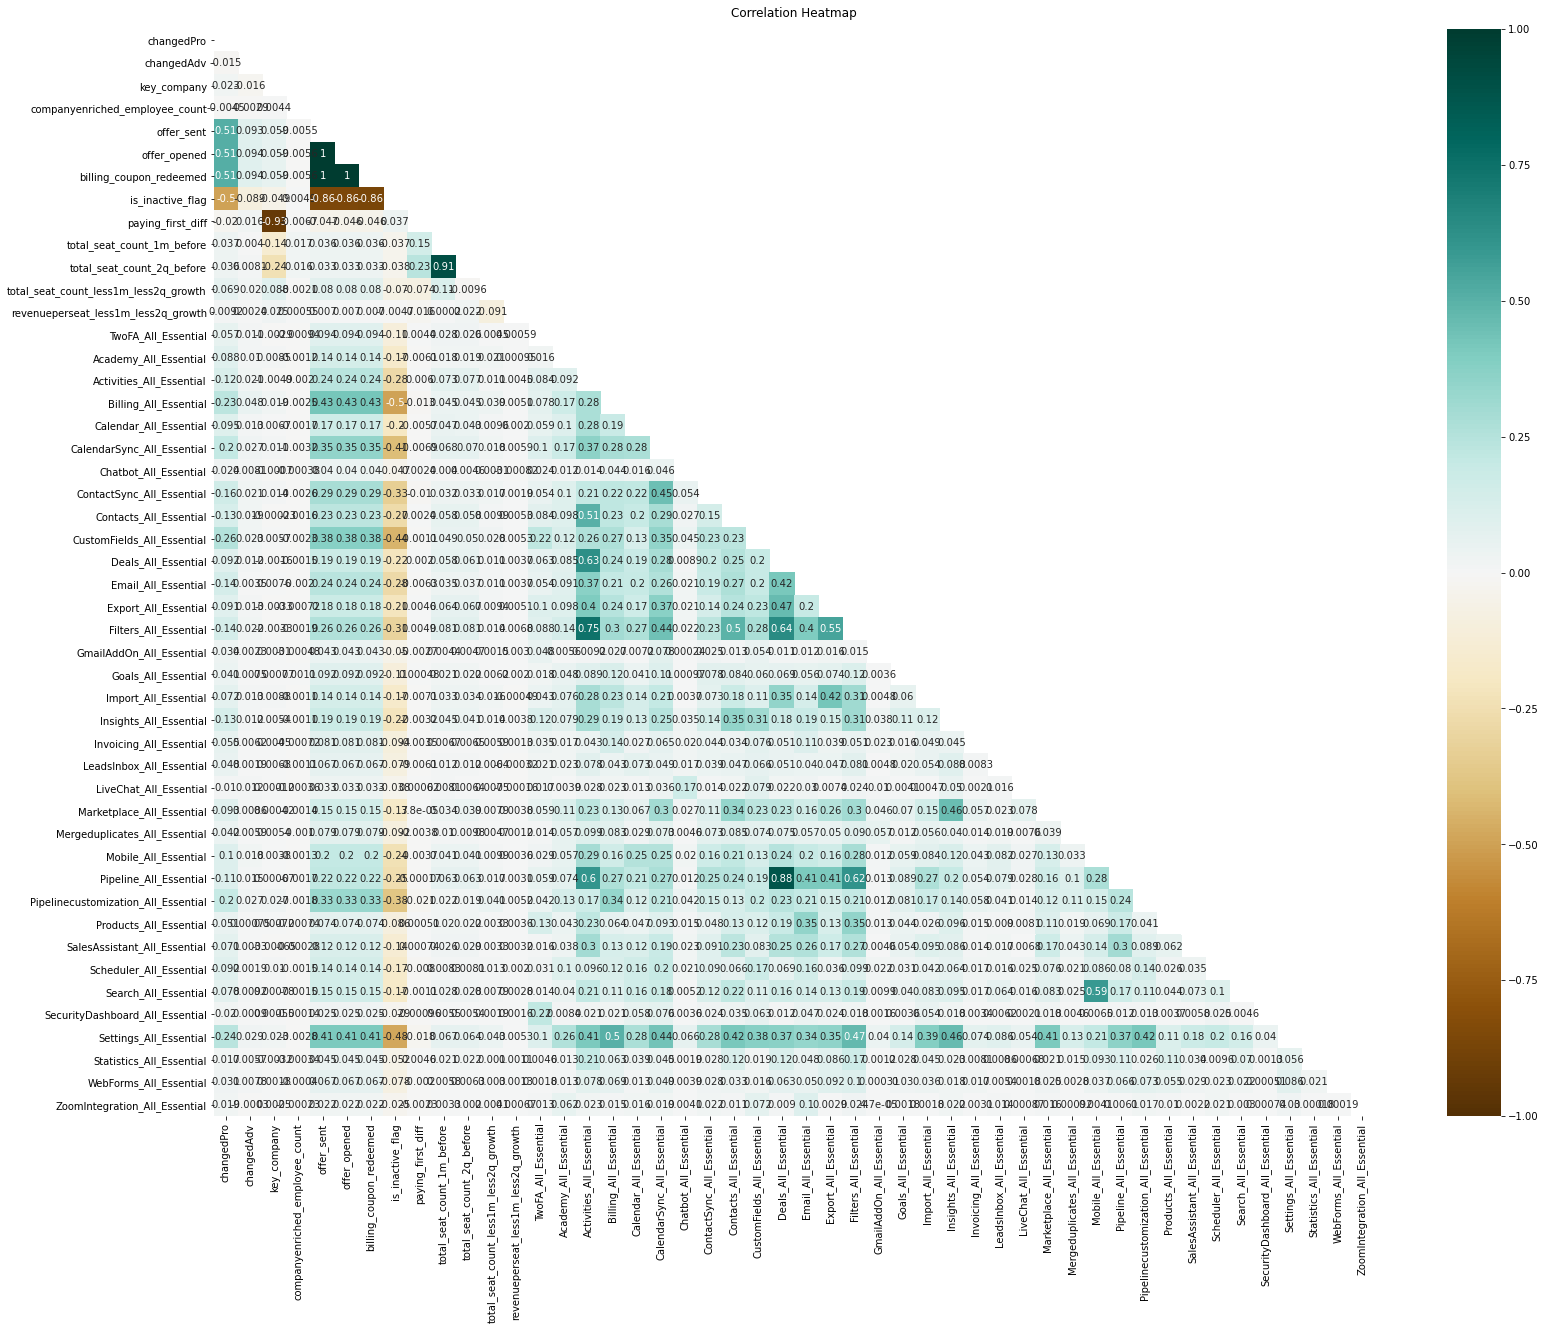

In [10]:
# Checking for correlations before scaling and encoding
plt.figure(figsize=(26, 20))

# Defining the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(raw.corr(), dtype=np.bool))

heatmap = sns.heatmap(raw.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [11]:
# Splitting categorical and continuous columns
categorical = df[['class_numeric', 'subregion', 'key_companyindustry', 'key_companyenrichedindustrygroup', 'key_companyenrichedsize']]
continuous = df[['month', 'paying_first_diff', 'total_seat_count_1m_before', 'total_seat_count_2q_before', 'total_seat_count_less1m_less2q_growth', 'company_mrr_fx_usd_1m_before',\
                 'company_mrr_fx_usd_2q_before', 'deal_revenue_2m_before', 'deal_revenue_less1m_less2q_growth',\
                 'revenueperseat_less1m_less2q_growth', 'TwoFA_All_Essential', 'Academy_All_Essential',\
                 'Activities_All_Essential', 'Billing_All_Essential', 'Calendar_All_Essential', 'CalendarSync_All_Essential',\
                 'Chatbot_All_Essential', 'ContactSync_All_Essential', 'Contacts_All_Essential', 'CustomFields_All_Essential',\
                 'Deals_All_Essential', 'Email_All_Essential', 'Export_All_Essential', 'Filters_All_Essential',\
                 'GmailAddOn_All_Essential', 'Goals_All_Essential', 'Import_All_Essential', 'Insights_All_Essential',\
                 'Invoicing_All_Essential', 'LeadsInbox_All_Essential', 'LiveChat_All_Essential', 'Marketplace_All_Essential',\
                 'Mergeduplicates_All_Essential', 'Mobile_All_Essential', 'Pipeline_All_Essential',\
                 'Pipelinecustomization_All_Essential', 'Products_All_Essential', 'SalesAssistant_All_Essential',\
                 'Scheduler_All_Essential', 'Search_All_Essential', 'SecurityDashboard_All_Essential', 'Settings_All_Essential',\
                 'Statistics_All_Essential', 'WebForms_All_Essential', 'ZoomIntegration_All_Essential']]


### Scaling & One Hot Encoding

In [12]:
# Wrapper for later scaling on group level
import typing
import pandas as pd

class SklearnWrapper:
    def __init__(self, transform: typing.Callable):
        self.transform = transform

    def __call__(self, df):
        transformed = self.transform.fit_transform(df.values)
        return pd.DataFrame(transformed, columns=df.columns, index=df.index)

In [13]:
# Scale numerical fields on month level (to avoid data differences between historic and current lines, e.g. different features usage or December drops)
from sklearn.preprocessing import MinMaxScaler

continuous = (
    continuous.groupby('month')
    .apply(SklearnWrapper(MinMaxScaler()))
)


In [14]:
# Merge scaled data into the final dataframe
df = pd.concat([categorical, continuous], axis=1)

In [15]:
# One Hot Encode categorical features
df = pd.get_dummies(df, columns = categorical.columns[1:])

In [16]:
# Dropping irrelevant columns creatind with one hot encoding
df = df.drop(columns = ['key_companyindustry_--', 'key_companyenrichedindustrygroup_--', 'key_companyenrichedsize_--'])

In [17]:
# Filling any existing nulls
df = df.fillna(0)

In [18]:
# Undersampling sleeping (to 0.5%) and trial_converted (to 60%) classes
df = df.drop(df[df['class_numeric'] == 0].sample(frac=0.995, random_state = 42).index)
df = df.drop(df[df['class_numeric'] == 1].sample(frac=0.4, random_state = 42).index)

In [19]:
# Checking class proportions
#df.groupby(['class_numeric']).size()

Text(0.5, 1.0, 'Correlation Heatmap')

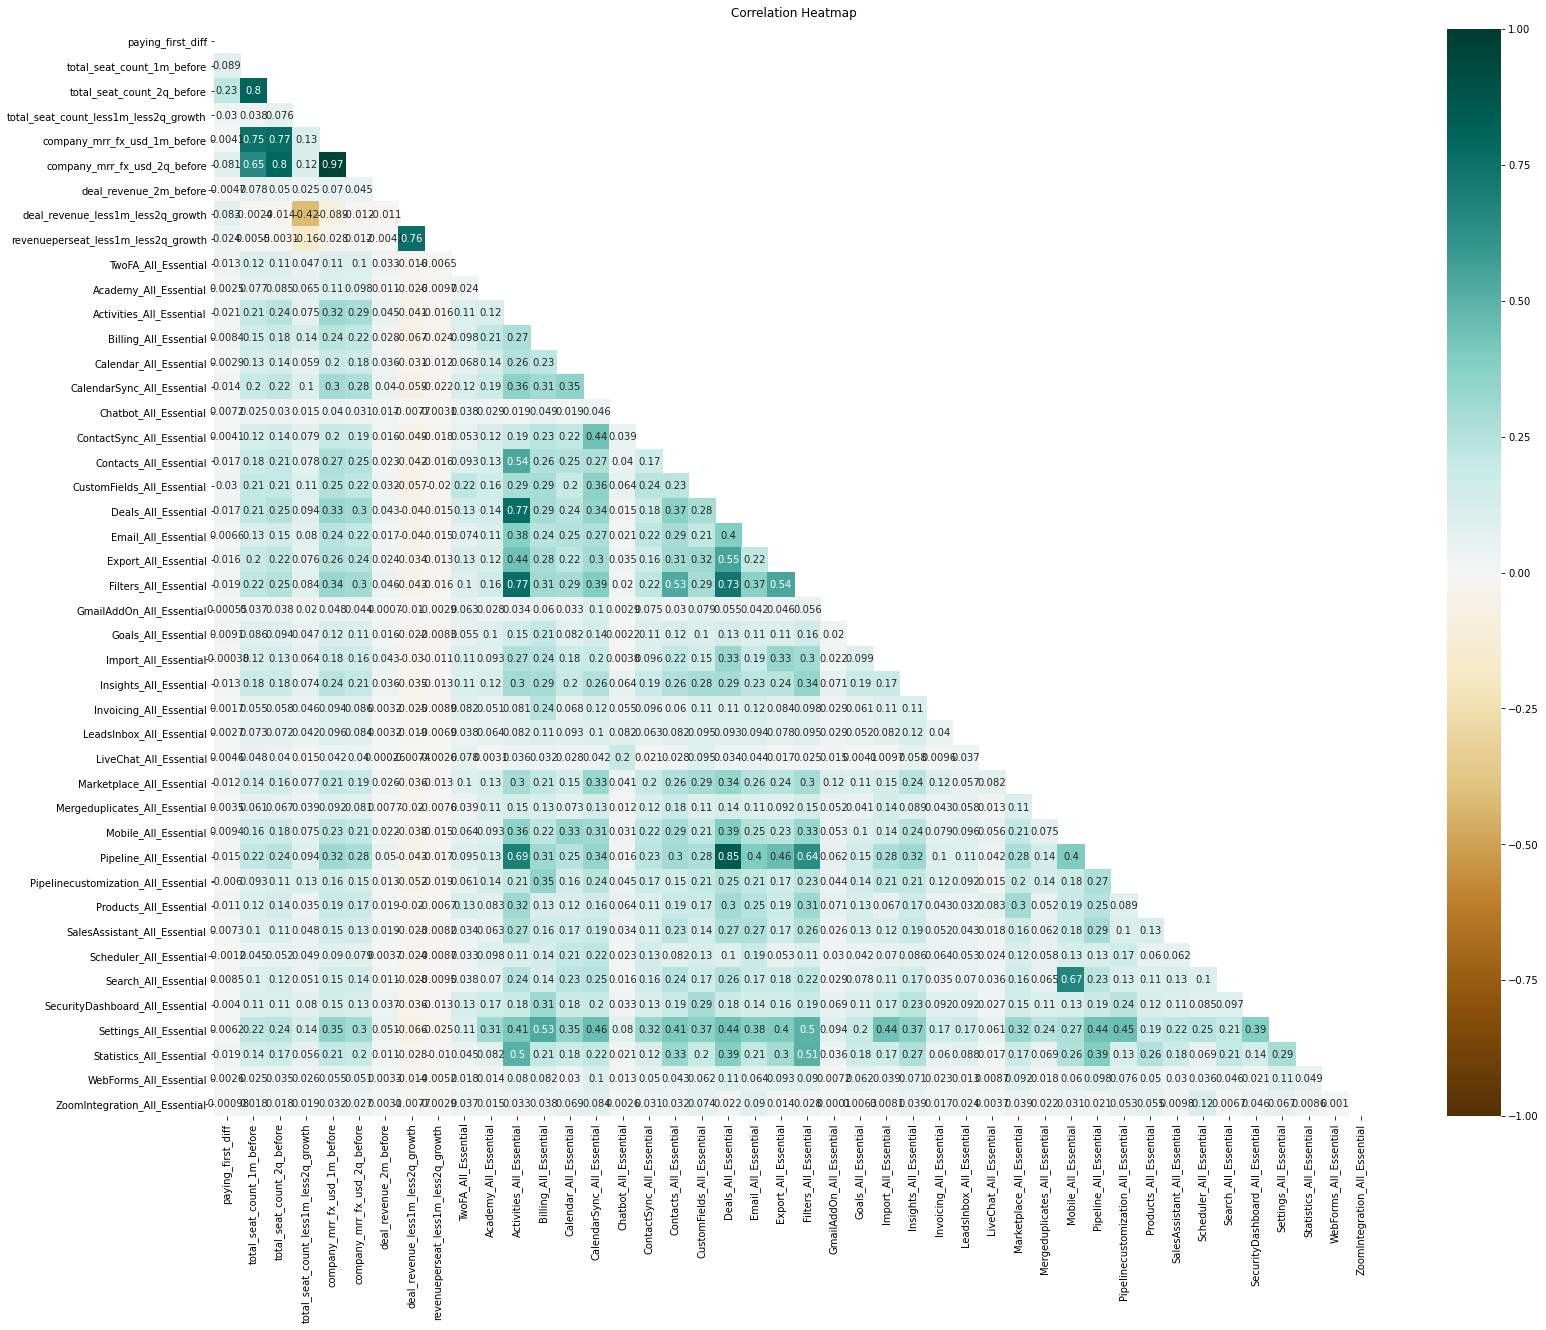

In [20]:
# Visualise correlation between numerical variables after encoding and scaling
plt.figure(figsize=(26, 20))

mask = np.triu(np.ones_like(df[continuous.columns].corr(), dtype=np.bool))

heatmap = sns.heatmap(continuous.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [21]:
# Look for highly correlated pairs
pd.set_option('display.max_rows', 100)
corr_matrix = df[continuous.columns].corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
    
print(sol[:50])

In [22]:
# Remove highly correlated pairs
df = df.drop(columns=['company_mrr_fx_usd_2q_before','total_seat_count_2q_before', 'Pipeline_All_Essential'])

### Splitting Data to Train, Test, Validate Sets

In [23]:
# Splitting data into train, test, validate dataframes and file paths
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.1, random_state=42)
train, validate = train_test_split(train, test_size=0.1, random_state=42)

In [24]:
# Reading train data into file in S3
train_path=f'''{path_to_file}input/train.csv'''

train.to_csv(train_path, header=False, index=False)

print('Train data set saved to', train_path)

In [25]:
# Reading test data into file in S3
test_path=f'''{path_to_file}input/test.csv'''

test.to_csv(test_path, header=False, index=False)

print('Test data set saved to', test_path)

In [26]:
# Reading validate data into file in S3
validate_path=f'''{path_to_file}input/validate.csv'''

validate.to_csv(validate_path, header=False, index=False)
print('Validate data set saved to', validate_path)

In [27]:
features = test.columns.to_list()
features

### Building Base Model & Training

In [28]:
from sagemaker import image_uris, get_execution_role
from sagemaker.session import Session
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import HyperparameterTuner
from sagemaker.tuner import ContinuousParameter, IntegerParameter
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

In [29]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html
# Initialize hyperparameters
hyperparameters = {
    'learning_rate': '0.1',
    'max_depth': '3',
    'min_child_weight': '1',
    'alpha': '50', 
    'gamma': '0',
    'subsample': '0.8',
    'colsample_bytree': '0.8',
    'num_round': '500',
    'objective': 'multi:softmax',
    'num_class': '3',
    'eval_metric': 'merror',
    'num_class': '3',
    'seed' : '42'
}

# Setting an output path where the trained model will be saved
output_path = f'''{path_to_file}output'''
region = 'eu-central-1'
content_type = 'csv'
save_interval = 5

# Creating xgboost container
xgboost_container = image_uris.retrieve('xgboost', region, '1.2-2')

# Initializing rules for the model
rules=[
    Rule.sagemaker(rule_configs.create_xgboost_report())
]

# Constructing a SageMaker estimator that calls the xgboost-container
estimator = Estimator(image_uri=xgboost_container, 
                      hyperparameters=hyperparameters,
                      role=get_execution_role(),
                      instance_count=1, 
                      instance_type='ml.m5.xlarge', 
                      volume_size=100, 
                      use_spot_instances=True,
                      max_wait=3600, 
                      max_run=3600,
                      output_path=output_path,
                      rules=rules
                     )

# Defining the data type and paths to the training and validation datasets
train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(test_path, content_type=content_type)

### Hyperparameter Tuning

In [30]:
# Defining hyperparameter ranges
hyperparameter_ranges = {
    'max_depth': IntegerParameter(1, 10), 
    'subsample': ContinuousParameter(0.5, 1), 
    'colsample_bytree': ContinuousParameter(0.5, 1), 
    'min_child_weight':IntegerParameter(1, 10),   
    'gamma':  IntegerParameter(0, 40),
    'alpha': IntegerParameter(10, 80), 
    'num_round': IntegerParameter(100, 700),
    'eta': ContinuousParameter(0, 1),
    'lambda': ContinuousParameter(1,5)
    
}

# Initializing hyperparameter tuner
tuner = HyperparameterTuner(estimator=estimator, 
                            base_tuning_job_name='uplift',
                            objective_metric_name='validation:merror',
                            objective_type='Minimize',
                            hyperparameter_ranges=hyperparameter_ranges,
                            max_jobs=3, 
                            max_parallel_jobs=3)


# Executing XGBoost tunining job
tuner.fit({'train': train_input, 'validation': validation_input})

.......................................................!


In [31]:
# Retreiving best training job name
best_training = tuner.best_training_job()

In [32]:
# Retreiving training job base  
best_training_base = best_training[:18]

In [33]:
# Creating analytics dataframe about the tuning jobs' performances
tuner.analytics().dataframe()

,alpha,colsample_bytree,eta,gamma,lambda,max_depth,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,14.0,0.843672,0.232944,33.0,3.268353,5.0,6.0,611.0,0.593597,uplift-210702-1215-003-0ba0dc2e,Completed,0.32027,2021-07-02 12:17:48+00:00,2021-07-02 12:19:12+00:00,84.0
1,61.0,0.778013,0.744726,34.0,4.461260,5.0,5.0,148.0,0.519868,uplift-210702-1215-002-f26aff6e,Completed,0.36622,2021-07-02 12:17:43+00:00,2021-07-02 12:18:46+00:00,63.0
2,78.0,0.830496,0.567357,5.0,3.953750,2.0,8.0,201.0,0.930528,uplift-210702-1215-001-90b45930,Completed,0.31622,2021-07-02 12:17:25+00:00,2021-07-02 12:18:32+00:00,67.0


In [34]:
# Retreiving the best estimator from the tuning jobs
tuner = HyperparameterTuner.attach(best_training_base) 
best_estimator = tuner.best_estimator()
best_estimator


2021-07-02 12:18:32 Starting - Preparing the instances for training
2021-07-02 12:18:32 Downloading - Downloading input data
2021-07-02 12:18:32 Training - Training image download completed. Training in progress.
2021-07-02 12:18:32 Uploading - Uploading generated training model
2021-07-02 12:18:32 Completed - Training job completed


### Transforming

In [35]:
# Initializing a transformer for the best_estimator to predict on validation dataset
transformer = best_estimator.transformer(
    instance_type='ml.m5.xlarge',
    instance_count=1,
    output_path=output_path,
    accept='text/csv',
    assemble_with='Line'
)


print('Output will be save to', output_path)

In [36]:
# Transforming the validation dataset
transformer.transform(
    validate_path,
    content_type='text/csv',
    input_filter='$[1:]',
    split_type='Line',
    join_source='Input',
    output_filter='$[0,-1]' 
)

.........................[2021-07-02:12:23:57:INFO] No GPUs detected (normal if no gpus installed)
[2021-07-02:12:23:57:INFO] No GPUs detected (normal if no gpus installed)
[2021-07-02:12:23:57:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }

    location / {
      return 404 "{}";
    }

  }
}


[2021-07-02 12:23:58 +0000] [20] [INFO] Starting

In [37]:
# Creating a true value and prediction dataset
predict_df = pd.read_csv(f'''{output_path}/validate.csv.out''', names=['class_numeric', 'score'])
predict_df

### Classification Report & Confusion Matrics

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score,recall_score, log_loss
from sklearn.metrics import accuracy_score

# Calculate performance metrics
perfomance_metrics = classification_report(predict_df['class_numeric'], predict_df['score'])
print(perfomance_metrics)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       217
           1       0.65      0.57      0.61       250
           2       0.55      0.60      0.58       199

    accuracy                           0.72       666
   macro avg       0.72      0.73      0.72       666
weighted avg       0.72      0.72      0.72       666



In [39]:
# Calculating model accuracy
accuracy = accuracy_score(predict_df['class_numeric'], predict_df['score'])
f1_score = f1_score(predict_df['class_numeric'], predict_df['score'], average='micro')
precision_score = precision_score(predict_df['class_numeric'], predict_df['score'], average='micro')
recall_score = recall_score(predict_df['class_numeric'], predict_df['score'], average='micro')



print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1: %.2f%%" % (f1_score * 100.0))
print("Precision score: %.2f%%" % (precision_score * 100.0))
print("Recall score: %.2f%%" % (recall_score * 100.0))

Accuracy: 72.07%
F1: 72.07%
Precision score: 72.07%
Recall score: 72.07%


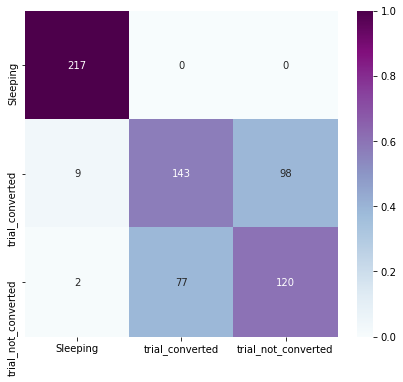

In [40]:
# Creating confusion matrix
cm = confusion_matrix(predict_df['class_numeric'], predict_df['score'])

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap="BuPu")

plot_confusion_matrix(cm, ['Sleeping', 'trial_converted', 'trial_not_converted'])

### Manually Configuring Best Model for Observing Eval Metric

In [41]:
# Retreiving best hyperparameters from tuning job
client = boto3.client('sagemaker')
job = client.describe_training_job(TrainingJobName=best_training)
hyperparameters = job['HyperParameters']

In [42]:
estimator = Estimator(image_uri=xgboost_container, 
                      hyperparameters=hyperparameters,
                      role=get_execution_role(),
                      instance_count=1, 
                      instance_type='ml.m5.xlarge', 
                      volume_size=100,
                      use_spot_instances=True,
                      max_wait=3600, 
                      max_run=3600,
                      output_path=output_path,
                      debugger_hook_config=DebuggerHookConfig(
                          s3_output_path=f'''{output_path}/debugger''',
                          collection_configs=[
                              CollectionConfig(
                                  name='metrics',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              ),
                              CollectionConfig(
                                  name='feature_importance',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              ),
                             CollectionConfig(
                                  name='full_shap',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              ),
                              CollectionConfig(
                                  name='average_shap',
                                  parameters={
                                      'save_interval': str(save_interval)
                                  }
                              )
                          ]
                      ),
                      rules=[
                            Rule.sagemaker(
                                rule_configs.loss_not_decreasing(),
                                rule_parameters={
                                    'collection_names': 'metrics',
                                    'num_steps': str(save_interval * 2),
                                },
                            ),
                        ]
                     )

train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(test_path, content_type=content_type)

estimator.fit({'train': train_input, 'validation': validation_input})

2021-07-02 12:24:43 Starting - Starting the training job...
2021-07-02 12:25:06 Starting - Launching requested ML instancesLossNotDecreasing: InProgress
ProfilerReport-1625228683: InProgress
...
2021-07-02 12:25:38 Starting - Preparing the instances for training............
2021-07-02 12:27:38 Downloading - Downloading input data
2021-07-02 12:27:38 Training - Downloading the training image.....[2021-07-02 12:28:20.116 ip-10-0-118-48.eu-central-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-02:12:28:20:INFO] Imported framework sagemaker_xgboost_container.training
[2021-07-02:12:28:20:INFO] Failed to parse hyperparameter eval_metric value merror to Json.
Returning the value itself
[2021-07-02:12:28:20:INFO] Failed to parse hyperparameter _tuning_objective_metric value validation:merror to Json.
Returning the value itself
[2021-07-02:12:28:20:INFO] Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
[2021-0

[76]#011train-merror:0.31391#011validation-merror:0.31622
[77]#011train-merror:0.31391#011validation-merror:0.31622
[78]#011train-merror:0.31391#011validation-merror:0.31622
[79]#011train-merror:0.31391#011validation-merror:0.31622
[80]#011train-merror:0.31391#011validation-merror:0.31622
[81]#011train-merror:0.31391#011validation-merror:0.31622
[82]#011train-merror:0.31391#011validation-merror:0.31622
[83]#011train-merror:0.31391#011validation-merror:0.31622
[84]#011train-merror:0.31391#011validation-merror:0.31622
[85]#011train-merror:0.31391#011validation-merror:0.31622
[86]#011train-merror:0.31391#011validation-merror:0.31622
[87]#011train-merror:0.31391#011validation-merror:0.31622
[88]#011train-merror:0.31391#011validation-merror:0.31622
[89]#011train-merror:0.31391#011validation-merror:0.31622
[90]#011train-merror:0.31391#011validation-merror:0.31622
[91]#011train-merror:0.31391#011validation-merror:0.31622
[92]#011train-merror:0.31391#011validation-merror:0.31622
[93]#011train-


2021-07-02 12:33:24 Uploading - Uploading generated training model
2021-07-02 12:33:48 Completed - Training job completed
ProfilerReport-1625228683: NoIssuesFound
Training seconds: 366
Billable seconds: 117
Managed Spot Training savings: 68.0%


### Debugger XGBoost Training Report

In [43]:
#!pip install smdebug

In [44]:
debug_report = estimator.latest_job_debugger_artifacts_path()
print(debug_report)

In [ ]:
from smdebug.trials import create_trial

s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

In [46]:
print(trial.collection("feature_importance").tensor_names)

### Feature Importance

In [47]:
#!pip install shap

In [48]:
import shap
from itertools import islice
import matplotlib.pyplot as plt

import re

feature_names = list(train.columns)
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1]=="f{}".format(str(ifeat)): return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = (trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

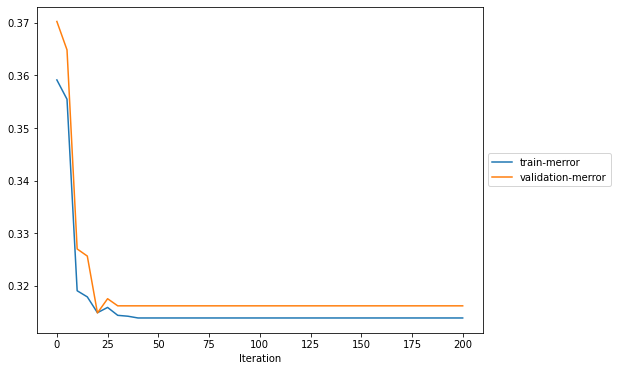

In [90]:
# Vislualizing eval metric performance thourghout the trainning job
plot_collection(trial, "metrics")
plt.savefig('eval_metrics.png')

In [50]:
# Loading Best Model for Generating Feature Importance
#!pip install xgboost
import tarfile
import pickle as pkl
from pprint import pprint

path_to_model = "markus_teimann/upliftmodel"
key = f'''{path_to_model}/output/{best_training}/output/model.tar.gz'''
boto3.resource('s3').Bucket('pdw-users').download_file(key, 'model.tar.gz')

t = tarfile.open('model.tar.gz', 'r:gz')
t.extractall()

model_file_path = 'xgboost-model'

model = pkl.load(open(model_file_path, 'rb'))

pprint(vars(model))

In [51]:
# Creating the shap dataframe 
shap_df = train.drop('class_numeric', axis=1)

In [52]:
# Creating shap values and visualizing feature importances
explainer = shap.TreeExplainer(model, data=shap_df)
shap_values = explainer.shap_values(shap_df)

 98%|===================| 17672/17967 [00:56<00:00]        

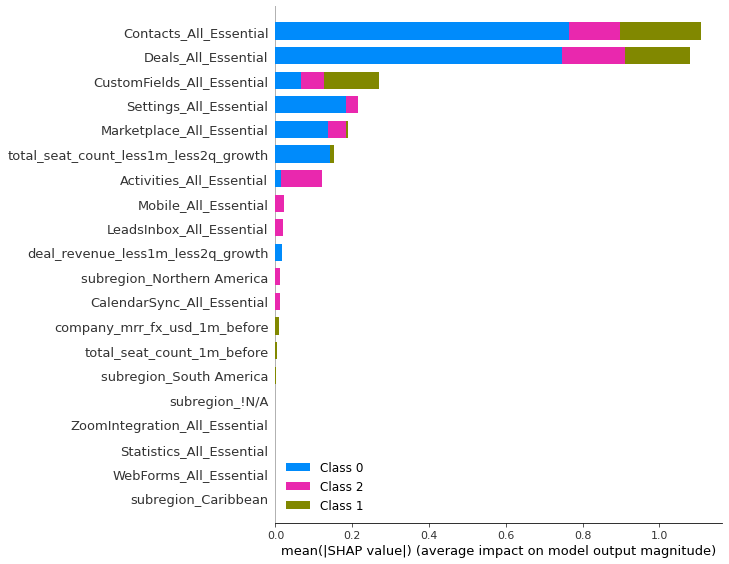

In [53]:
shap.summary_plot(shap_values, shap_df, plot_type="bar", show=False)
plt.savefig('shap_summary_bar.png')

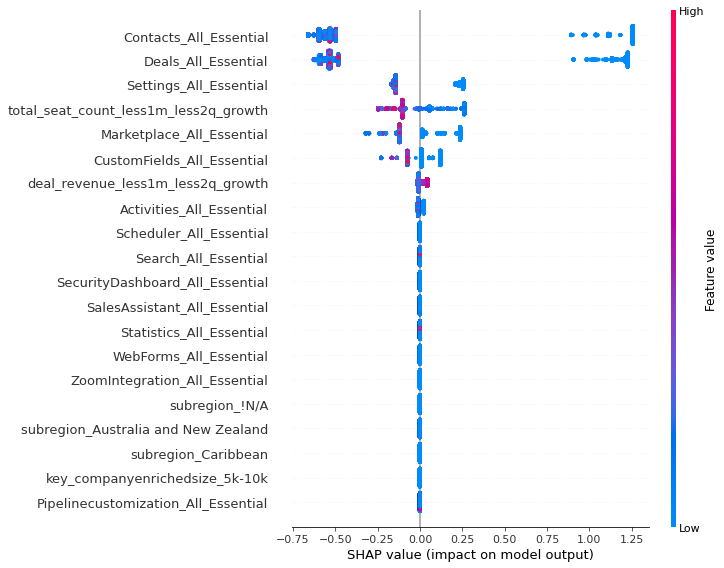

In [54]:
shap.summary_plot(shap_values[0], shap_df, show=False)
plt.savefig('shap_summary_0.png')

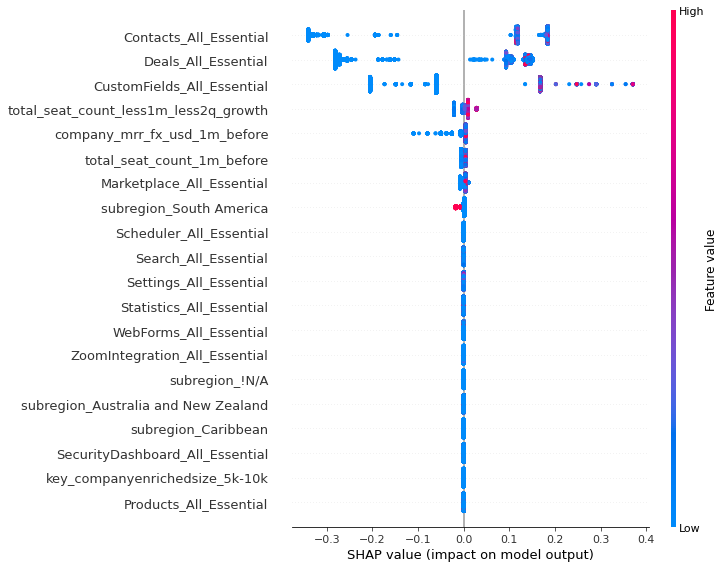

In [55]:
shap.summary_plot(shap_values[1], shap_df, show=False)
plt.savefig('shap_summary_1.png')

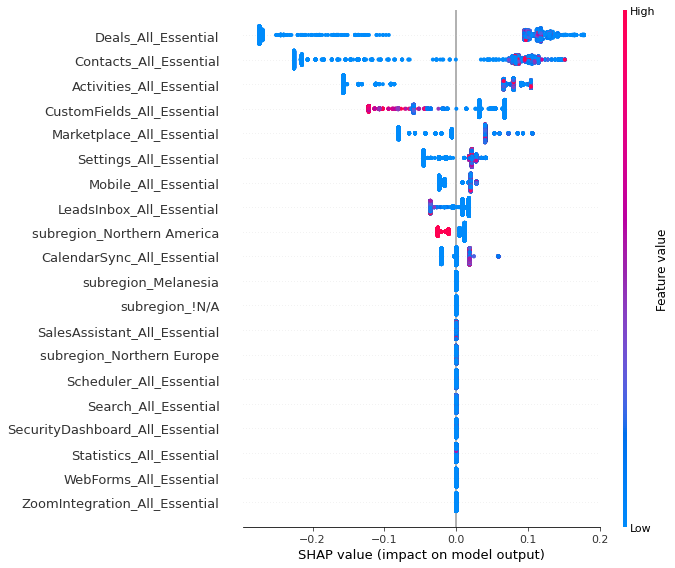

In [56]:
shap.summary_plot(shap_values[2], shap_df, show=False)
plt.savefig('shap_summary_2.png')

### Extratcting Influencial Features and Predicting

In [57]:
# Retreiving most important features based on shap 
shap_vals = np.abs(shap_values).mean(axis=1)
importance = np.add(shap_vals[0], shap_vals[1], shap_vals[2])
feature_importance = pd.DataFrame(list(zip(shap_df.columns, importance)), columns=['feature', 'importance'])
feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)

In [58]:
# Setting a treshold and filtering out important features based on shap values
important_features = feature_importance.loc[feature_importance['importance'] > 0.0005]['feature'].to_list()

In [59]:
# Creating new train, test, and validation sets only including relevant features
important_features = ['class_numeric'] + important_features
important_df = df[important_features]

train, test = train_test_split(important_df, test_size=0.1, random_state=42)
train, validate = train_test_split(train, test_size=0.1, random_state=42)

In [ ]:
# Saving datasets to S3
train.to_csv(train_path, header=False, index=False)
print('Train data set saved to', train_path)

test.to_csv(test_path, header=False, index=False)
print('Test data set saved to', test_path)

validate.to_csv(validate_path, header=False, index=False)
print('Validate data set saved to', validate_path)

In [61]:
# Creating a new estimator for updated dataset with best features
new_estimator = Estimator(image_uri=xgboost_container, 
                      hyperparameters=hyperparameters,
                      role=get_execution_role(),
                      instance_count=1, 
                      instance_type='ml.m5.xlarge', 
                      volume_size=100, 
                      use_spot_instances=True,
                      max_wait=3600, 
                      max_run=3600,
                      output_path=output_path,
                      rules=rules
                     )

train_input = TrainingInput(train_path, content_type=content_type)
validation_input = TrainingInput(test_path, content_type=content_type)

new_estimator.fit({'train': train_input, 'validation': validation_input})

2021-07-02 12:36:03 Starting - Starting the training job...
2021-07-02 12:36:26 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1625229362: InProgress
...
2021-07-02 12:36:57 Starting - Preparing the instances for training......
2021-07-02 12:38:04 Downloading - Downloading input data...
2021-07-02 12:38:26 Training - Downloading the training image...
2021-07-02 12:39:07 Uploading - Uploading generated training model[2021-07-02 12:38:54.503 ip-10-0-91-160.eu-central-1.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-02:12:38:54:INFO] Imported framework sagemaker_xgboost_container.training
[2021-07-02:12:38:54:INFO] Failed to parse hyperparameter eval_metric value merror to Json.
Returning the value itself
[2021-07-02:12:38:54:INFO] Failed to parse hyperparameter _tuning_objective_metric value validation:merror to Json.
Returning the value itself
[2021-07-02:12:38:54:INFO] Failed to parse hyperparameter objective


2021-07-02 12:39:27 Completed - Training job completed
Training seconds: 64
Billable seconds: 20
Managed Spot Training savings: 68.8%


In [ ]:
# Creating a new transformer for the new estimator
transformer = new_estimator.transformer(
    instance_type='ml.m5.xlarge',
    instance_count=1,
    output_path=output_path,
    accept='text/csv',
    assemble_with='Line'
)


print('Output will be save to', output_path)

In [63]:
# Transforming with the new estimator
transformer.transform(
    validate_path,
    content_type='text/csv',
    input_filter='$[1:]',
    split_type='Line',
    join_source='Input',
    output_filter='$[0,-1]' 
)

.....................................................................

In [64]:
predict_df = pd.read_csv(f'''{output_path}/validate.csv.out''', names=['class_numeric', 'score'])

In [77]:
# Calculate performance metrics
perfomance_metrics = classification_report(predict_df['class_numeric'], predict_df['score'])
print(perfomance_metrics)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       217
           1       0.65      0.56      0.60       250
           2       0.55      0.61      0.58       199

    accuracy                           0.72       666
   macro avg       0.72      0.72      0.72       666
weighted avg       0.72      0.72      0.72       666



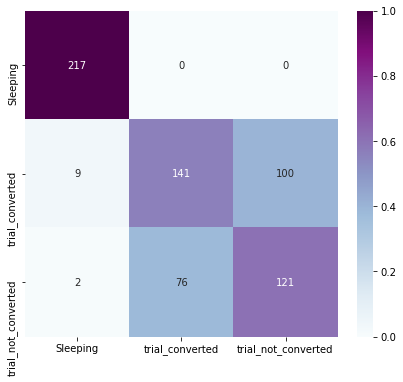

In [78]:
# Creating confusion matrix
cm = confusion_matrix(predict_df['class_numeric'], predict_df['score'])

plot_confusion_matrix(cm, ['Sleeping', 'trial_converted', 'trial_not_converted'])

To evaluate the performance of the model, we  compared its prediction of a test set with real values. The model succeeded to recognise all Sleeping customers (217), but there were few cases when it also marked as Sleeping a small number (11) of customers that belong to the other two classes. The prediction model has therefore slightly lower precision (0.95)  than recall (1.00) in case of this class (precision is calculated as a fraction of relevant instances among the retrieved instances, while recall is a fraction of relevant instances that were retrieved). 

The model is much less successful in recognising companies that remain on a higher plan even after the trial period. 141 of such companies were predicted correctly, but 76 of those predicted as converted were actually not. It means that it’s capable to retrieve 56% of relevant instances. We can see a bit better results in case of non-converters prediction with 121 of companies predicted as non-converted were really belonging to the group, but the model missed other 78 non-converters.

Altogether, the model has both weighted precision and weighted recall of 0.72. The result is mostly driven by good performance in recognition of the Sleeping class. This group, however, is made up of customers who are easily spotted by their (non)activity. Despite some common characteristics, the other two groups don’t follow the same patterns in all cases and are much harder to distinguish.

### Retrieveing Metrics & Implementing MLFlow

I also  implemented MLFlow that allows easily to capture model performance metrics thoughout the training process and save most important artifacts.

In [79]:
search_params={
   "MaxResults": 100,
   "Resource": "TrainingJob",
   "SearchExpression": { 
      "Filters": [{ 
            "Name": "TrainingJobName",
            "Operator": "Contains",
            "Value": "uplift-210628"
         }]},
  "SortBy": "Metrics.validation:merror",
  "SortOrder": "Descending"
}


results = client.search(**search_params)

In [80]:
import IPython.display

indexValue = 1

headers=["Index","Training Job Name", "Training Job Status", "Batch Size", "Validation Mean Error"]
rows=[]
for result in results['Results']: 
    trainingJob = result['TrainingJob']
    metrics = trainingJob['FinalMetricDataList']
    rows.append([indexValue,trainingJob['TrainingJobName'],
    trainingJob['TrainingJobStatus'],
    trainingJob['HyperParameters'],100*
    metrics[[x['MetricName'] for x in  
    metrics].index('validation:merror')]['Value']
    ])
    indexValue += 1

metrics_df = pd.DataFrame(data=rows,columns=headers)

In [81]:
file = open("metrics_df_values.txt", "a")
file.close()

In [82]:
np.savetxt("metrics_df_values.txt", metrics_df, delimiter=',', fmt='%s')

In [83]:
file = open("columns.txt", "a")
file.close()

In [84]:
np.savetxt("columns.txt", df.columns[1:], delimiter=',', fmt='%s')

In [85]:
file = open("perfomance_metrics.txt", "w")

file.write(perfomance_metrics)
file.close()

In [91]:
with mlflow.start_run(experiment_id = experiment_id, run_name = "Train model"):
    mlflow.log_param("train_location ", train_path)
    mlflow.log_param("test_location ", test_path)
    mlflow.log_param("validation_location ", validate_path)

    mlflow.log_artifact("shap_summary_bar.png")
    mlflow.log_artifact("shap_summary_0.png")
    mlflow.log_artifact("shap_summary_1.png")
    mlflow.log_artifact("shap_summary_2.png")
    mlflow.log_artifact("distribution.png")
    mlflow.log_artifact("metrics_df_values.txt")
    mlflow.log_artifact("columns.txt")
    mlflow.log_artifact("perfomance_metrics.txt")
    mlflow.log_artifact('eval_metrics.png')

In [87]:
mlflow.end_run()

In [88]:
mlflow.active_run()